# Dorothea

There are two ways of describing the city of Dorothea: you can say that four aluminum towers rise from its walls flanking seven gates with spring-operated drawbridges that span the moat whose water feeds four green canals which cross the city, dividing it into nine quarters, each with three hundred houses and seven hundred chimneys. And bearing in mind that the nubile girls of each quarter marry youths of other quarters and their parents exchange the goods that each family holds in monopoly -- bergamot, sturgeon roe, astrolabes, amethysts -- you can then work from these facts until you learn everything you wish about the city in the past, present, and future. Or else you can say, like the camel driver who took me there: “I arrived here in my first youth, one morning, many people were hurrying along the streets toward the market, the women had fine teeth and looked you straight in the eye, three soldiers on a platform played the trumpet, and all around wheels turned and colored banners fluttered in the wind. Before then I had known only the desert and the caravan routes. In the years that followed, my eyes returned to contemplate the desert expanses and the caravan routes; but now I know this path is only one of the many that opened before me on that morning in Dorothea.”

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

In [3]:
%matplotlib inline

In [21]:
%load_ext autoreload

In [22]:
%autoreload 2

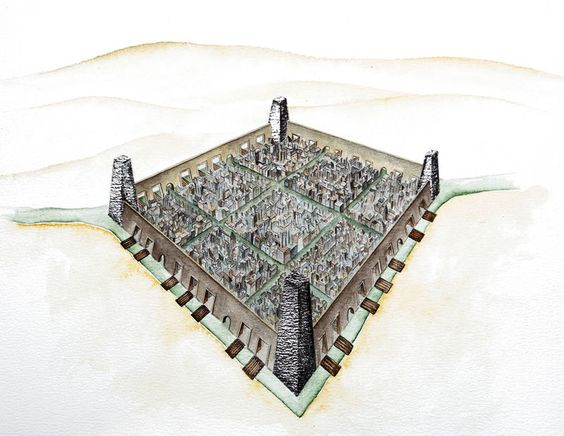

In [23]:
Image(filename='../../Images/Dorothea.jpg') 

## DOROTEA

In [24]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np

In [206]:
import mplFunctions as mpl
import PDFunctions as pdf
import wfmFunctions as wfm

In [27]:
#from PlotUtil import *
from Util import *
#from PandaUtil import *

In [28]:
import FEParam as FP

In [29]:
from scipy import signal as SGN

### Nominal calibration constant (adc_per_pes)

http://localhost:8989/notebooks/SIERPE.ipynb

In [30]:
adc_to_pes = 18.07  # in the MC this is fixed for all PMTs, in data it comes from calibration

In [31]:
% ls /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/

WF_Na_0_RWF.h5                   WF_Na_ZLIB_offset500_RWF.h5
WF_Na_1k.h5                      WF_Na_ZLIB_test2_RWF.h5
WF_Na_1k_RWF.h5                  WF_Na_ZLIB_test_RWF.h5
WF_Na_BLOSC_float32_RWF.h5       WF_Na_test_RWF.h5
WF_Na_BLOSC_test2_RWF.h5         WF_Tl_0.h5
WF_Na_RWF.h5                     WF_Tl_0_2.h5
WF_Na_ZLIB_float32_RWF.h5        WF_Tl_0_RWF.h5
WF_Na_ZLIB_offset500_100_RWF.h5  wf_bi.h5
WF_Na_ZLIB_offset500_10_RWF.h5


In [98]:
h5f =tb.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_offset500_RWF.h5', "r+")

In [65]:
 pmt_t = h5f.root.Sensors.DataPMT

In [66]:
PMT = pdf.read_data_sensors(pmt_t)

In [110]:
PMT

,active,adc_to_pes,channel,gain,x,y
0,1,20.0,0,4500000.0,23.9414,65.7785
1,1,20.0,1,4500000.0,-68.9365,-12.1554
2,1,20.0,2,4500000.0,44.9951,-53.6231
3,1,20.0,3,4500000.0,0.0000,185.0000
4,1,20.0,5,4500000.0,-118.9160,141.7180
5,1,20.0,6,4500000.0,-182.1890,32.1249
6,1,20.0,8,4500000.0,-160.2150,-92.5000
7,1,20.0,9,4500000.0,-63.2737,-173.8430
8,1,20.0,10,4500000.0,63.2737,-173.8430
9,1,20.0,12,4500000.0,160.2150,-92.5000


In [36]:
PMT['adc_to_pes'] = adc_to_pes

In [37]:
PMT

,active,adc_to_pes,channel,gain,x,y
0,1,18.07,0,4500000.0,23.9414,65.7785
1,1,18.07,1,4500000.0,-68.9365,-12.1554
2,1,18.07,2,4500000.0,44.9951,-53.6231
3,1,18.07,3,4500000.0,0.0000,185.0000
4,1,18.07,5,4500000.0,-118.9160,141.7180
5,1,18.07,6,4500000.0,-182.1890,32.1249
6,1,18.07,8,4500000.0,-160.2150,-92.5000
7,1,18.07,9,4500000.0,-63.2737,-173.8430
8,1,18.07,10,4500000.0,63.2737,-173.8430
9,1,18.07,12,4500000.0,160.2150,-92.5000


##### NB The value of adc_to_pes in changed in the temporary DF, not in file

In [83]:
pmtcwf = h5f.root.RD.pmtcwf

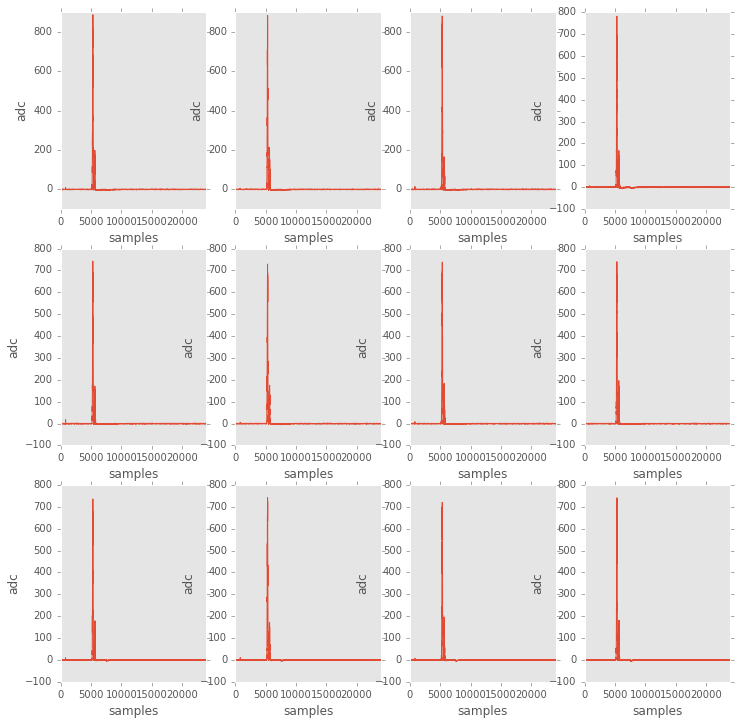

Press a key...


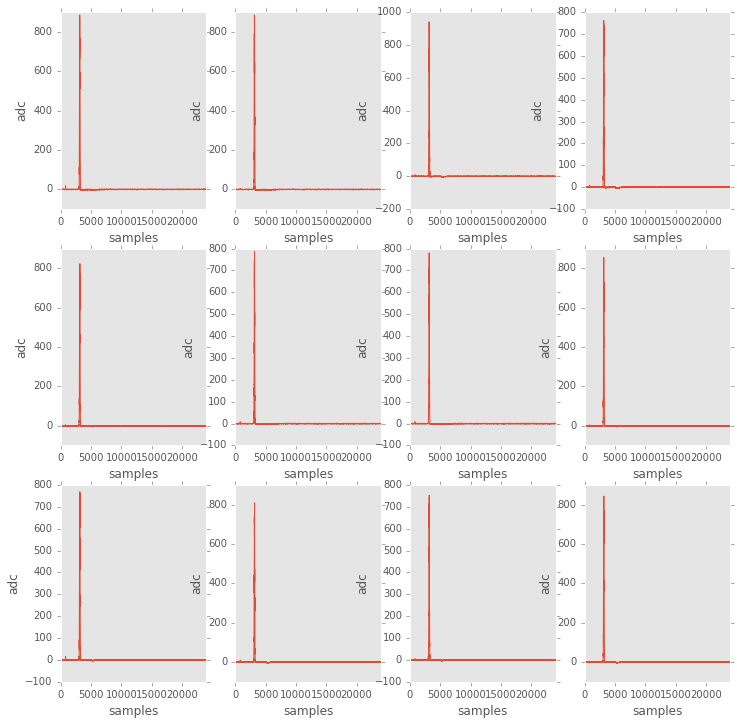

Press a key...


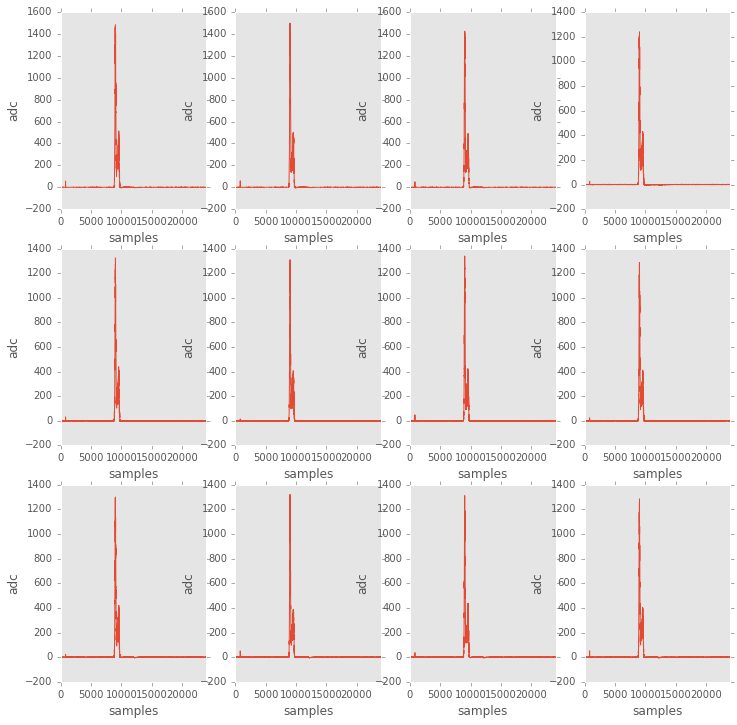

Press a key...


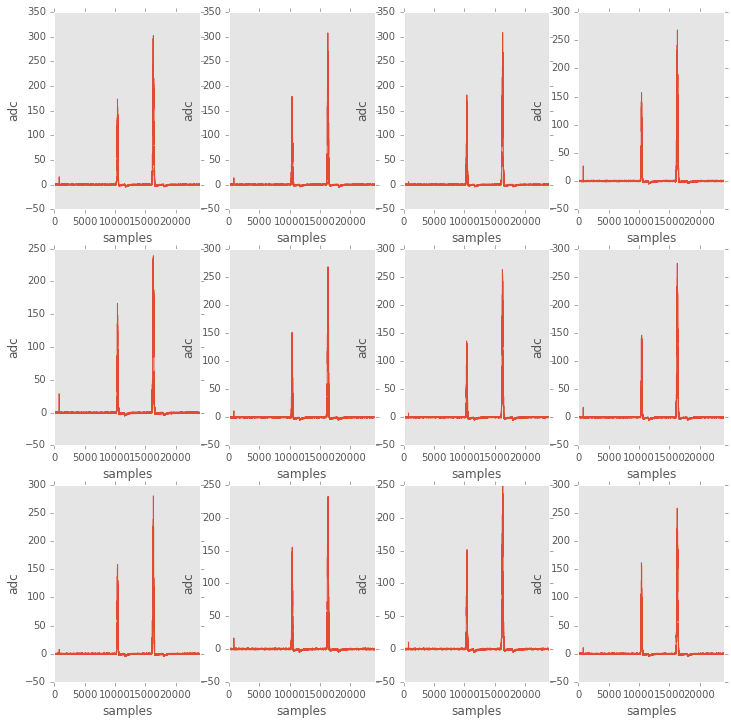

Press a key...


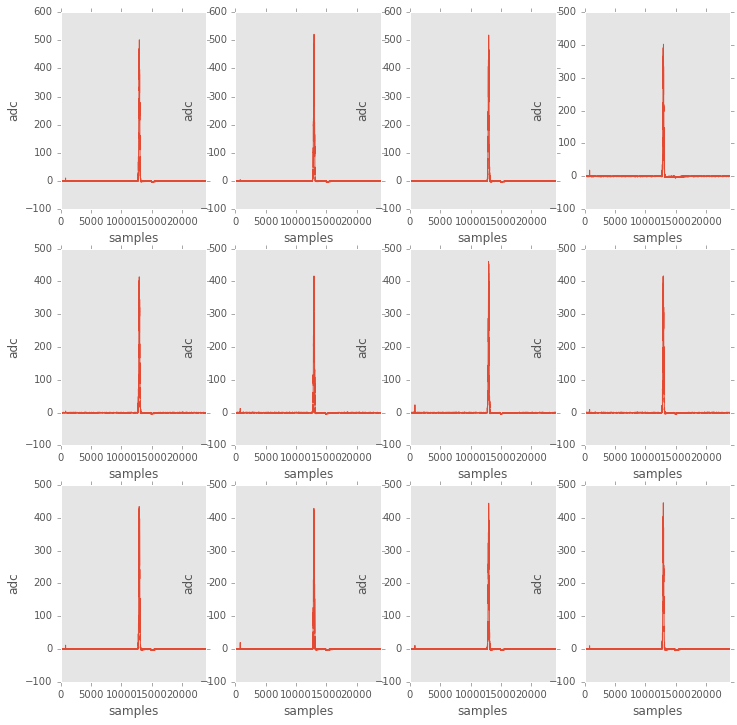

Press a key...


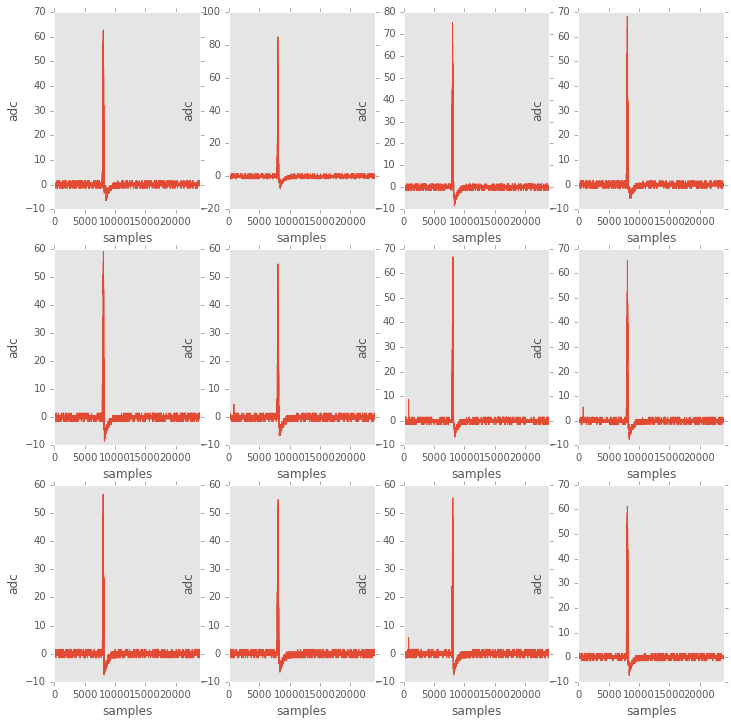

Press a key...


In [94]:
mpl.scan_waveforms(pmtcwf,list_of_events=range(6))

### Adding waveforms (calibrated)

#### add_cwf adds the waveform of each PMT in PES (divide by calibration constant) and returns a data frame

In [111]:
def wfdf(time_ns,energy_pes,indx):
    """
    takes three vectors (time, energy and indx) and returns a data frame representing a waveform
    """
    swf = {}
    swf['time_ns'] = time_ns
    swf['ene_pes'] = energy_pes 
    swf['indx'] = indx
    return pd.DataFrame(swf)

In [71]:
def add_cwf(cwfdf,pmtDF):
    """
    input: cwfdf: each colum is the wf for one PMT.
    output: swf is a data frame with two columns:
    time_ns = counts the time in ns
    ene_pes = conths the energy in pes
    """
    wf =0
    NPMT = len(pmtDF)
    for i in range(NPMT):
        adc_to_pes = pmtDF['adc_to_pes'][i]
        wf += cwfdf[i].values/adc_to_pes
    
    return wfdf(np.array(range(len(wf)))*FP.time_DAQ, wf,np.array(range(len(wf))))

In [150]:
cwfdf = wfm.get_waveforms(pmtcwf,event_number=0)
swf = add_cwf(cwfdf,PMT)

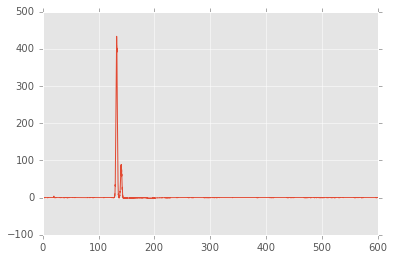

In [151]:
plt.plot(swf['time_ns']/mus, swf['ene_pes'])

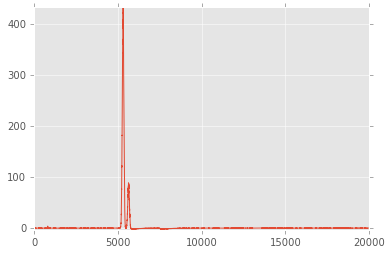

In [152]:
mpl.plts(swf['ene_pes'], signal_start=0, signal_end=20000, offset=1)

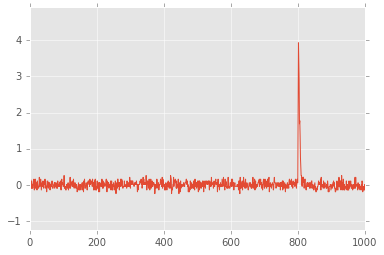

In [153]:
mpl.plts(swf['ene_pes'], signal_start=0, signal_end=1000, offset=1)

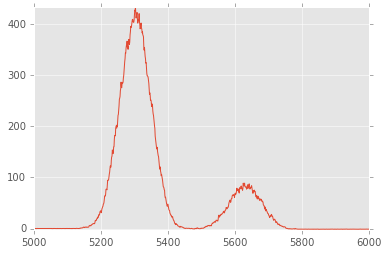

In [154]:
mpl.plts(swf['ene_pes'], signal_start=5000, signal_end=6000, offset=1)

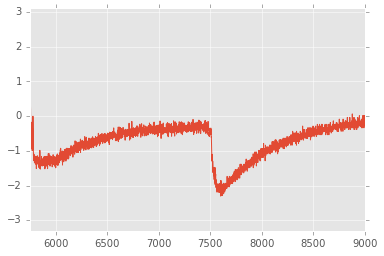

In [155]:
mpl.plts(swf['ene_pes'], signal_start=5750, signal_end=9000, offset=1)

In [156]:
ewf = sum(swf['ene_pes'].values)

In [157]:
ewf

55684.194364571944

In [117]:
cwfdf = pdf.get_waveforms(pmtcwf,event_number=1)
swf = add_cwf(cwfdf,PMT)

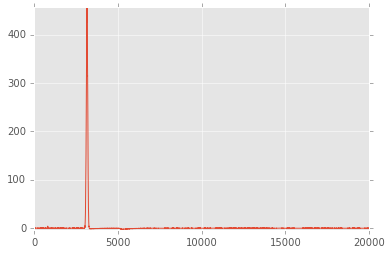

In [118]:
mpl.plts(swf['ene_pes'], signal_start=0, signal_end=20000, offset=1)

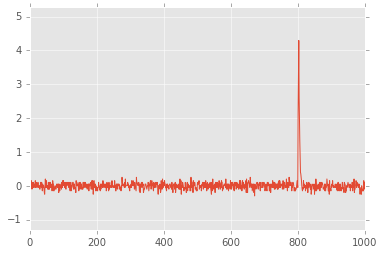

In [119]:
mpl.plts(swf['ene_pes'], signal_start=0, signal_end=1000, offset=1)

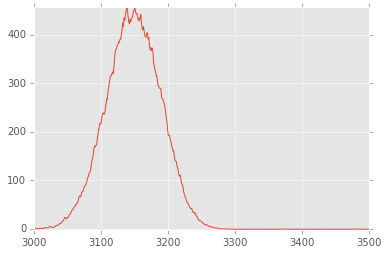

In [122]:
mpl.plts(swf['ene_pes'], signal_start=3000, signal_end=3500, offset=1)

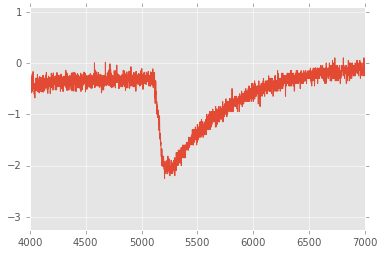

In [103]:
mpl.plts(swf['ene_pes'], signal_start=4000, signal_end=7000, offset=1)

In [214]:
def get_waveforms(pmtea,event_number=0):
    """
    Takes the earray pmtea and returns a DF for event_number
    """
    
    PMTWF ={}
    NPMT = pmtea.shape[1]
    
    for j in range(NPMT):
        PMTWF[j] = pmtea[event_number, j] #waveform for event event_number, PMT j
       
    return pd.DataFrame(PMTWF)

In [123]:
cwfdf = get_waveforms(pmtcwf,event_number=2)
swf = add_cwf(cwfdf,PMT)

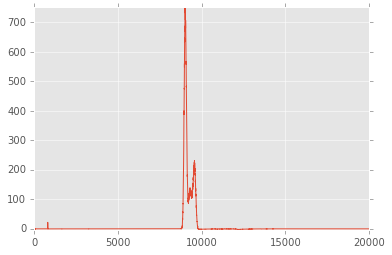

In [124]:
mpl.plts(swf['ene_pes'], signal_start=0, signal_end=20000, offset=1)

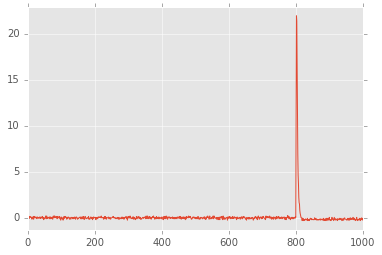

In [125]:
mpl.plts(swf['ene_pes'], signal_start=0, signal_end=1000, offset=1)

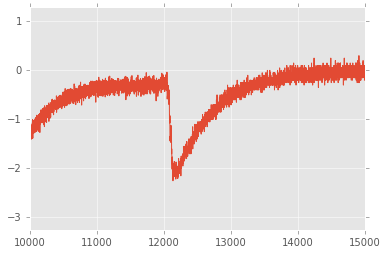

In [105]:
mpl.plts(swf['ene_pes'], signal_start=10000, signal_end=15000, offset=1)

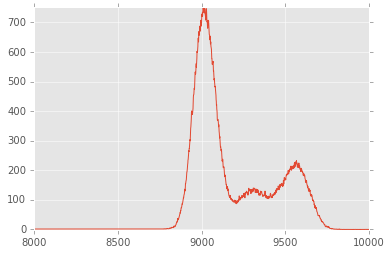

In [128]:
mpl.plts(swf['ene_pes'], signal_start=8000, signal_end=10000, offset=1)

In [216]:
cwfdf = get_waveforms(pmtcwf,event_number=3)
swf = add_cwf(cwfdf,PMT)

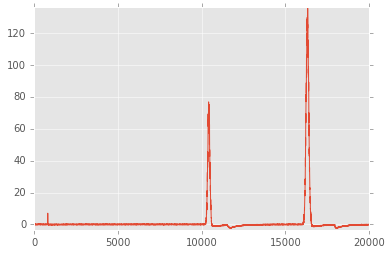

In [107]:
mpl.plts(swf['ene_pes'], signal_start=0, signal_end=20000, offset=1)

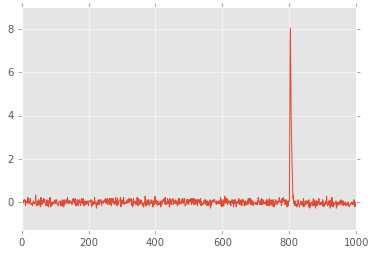

In [60]:
mpl.plts(swf['ene_pes'], signal_start=0, signal_end=1000, offset=1)

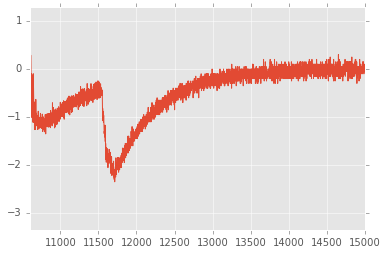

In [108]:
mpl.plts(swf['ene_pes'], signal_start=10600, signal_end=15000, offset=1)

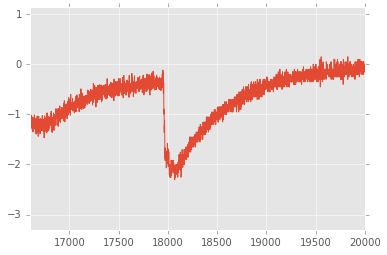

In [109]:
mpl.plts(swf['ene_pes'], signal_start=16600, signal_end=20000, offset=1)

#### Effect of baseline recovery

Tipically a dip up to -2/3 pes. The effect if more evident with a negative offset, since the subtraction of the baseline results in the dip being always negative. 

In [ ]:
def scan_SWF(pmtcwf,pmtDF,list_of_events=[0]):
    for event in list_of_events:
        cwfdf = get_waveforms(pmtcwf,event_number=event)
        swf = add_cwf(cwfdf,pmtDF)
        plt.plot(swf['time_ns']/mus, swf['ene_pes'])
        plt.show()
        wait()
  

#### The problem with rebinning

Baseline recovery is a sistematic effect that is exagerated by rebinning. In the swf the baseline recovers in 1 pes, the rebinned wf recovers in 40 pes. 

### Finding S1 and S2 signals

In [137]:
def wf_thr(wf,threshold=1):
    """
    return a zero supressed waveform (more generally, the vaules of wf above threshold)
    """
    return wf.loc[lambda df: df.ene_pes.values >threshold, :]
    

In [138]:
def find_S12(swf, stride=40):
    """
    Find S1 or S2 signals. The input is a zero-supressed WF. The stride defines the contiguity criterium.
    The stride is applied to the indexes which keep the ordering of the original (non-zs) WF. 
    For example, with a stride of 40 (corresponding to steps of 1 mus for a DAQ timing of 25 ns) index 1
    and index 39 are in the same S12. 
    """
    T = swf['time_ns'].values
    P = swf['ene_pes'].values
    I = swf['indx'].values
    
    S12 = {}
    pulse_on = 1
    j=0
    
    S12[0] = []
    S12[0].append([T[0],P[0],I[0]])
    
    for i in range(1,len(swf)) :
        if swf.index[i]-stride > swf.index[i-1]:  #new s12
            j+=1
            S12[j] = []
            S12[j].append([T[i],P[i],I[i]])
        else:
            S12[j].append([T[i],P[i],I[i]])
            
    S12L=[]
    for i in S12.keys():
        S12L.append(pd.DataFrame(S12[i], columns=['time_ns','ene_pes','indx']))
    return S12L
            

### S12 search

#### Threshold

In [139]:
NPMT = len(PMT)
adc_to_pes = PMT['adc_to_pes'][0]
nsigma=3
thr = nsigma*sqrt(NPMT)*FP.NOISE_ADC/adc_to_pes

In [140]:
thr 

0.9311505141490285

In [217]:
cwfdf = get_waveforms(pmtcwf,event_number=0)
swf = add_cwf(cwfdf,PMT)
swf_zs = wf_thr(swf,threshold=thr)

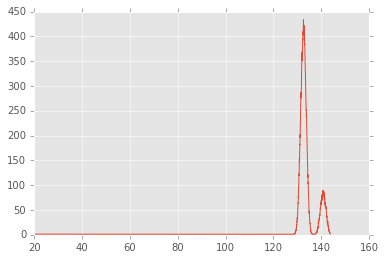

In [159]:
plt.plot(swf_zs['time_ns']/mus, swf_zs['ene_pes'])

In [160]:
s12 = find_S12(swf_zs)

In [161]:
len(s12)

2

In [162]:
s1 = s12[0]
s2 = s12[1]

In [163]:
s1

,time_ns,ene_pes,indx
0,20025.0,2.160400,801
1,20050.0,3.931180,802
2,20075.0,3.444754,803
3,20100.0,2.899949,804
4,20125.0,1.694272,805
5,20150.0,1.778194,806
6,20175.0,1.344966,807


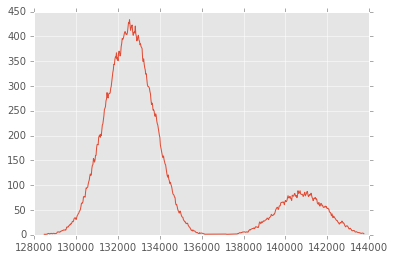

In [164]:
plt.plot(s2['time_ns'], s2['ene_pes'])

### Energy of S2

In [166]:
es2 =np.sum(s2.ene_pes.values)

In [169]:
print(" ewf = {} pes; es2 = {} pes ".format(ewf,es2))

 ewf = 55684.1943646 pes; es2 = 57955.6189763 pes 


#### Notice that es2 > ewf, since we are eliminating the negative dip associated to the BLR

### An example with two S2

##### For the following examples we use the same functions already saved in wfmFunctions.py

In [218]:
cwfdf = wfm.get_waveforms(pmtcwf,event_number=3)
swf = wfm.add_cwf(cwfdf,PMT)
swf_zs = wfm.wf_thr(swf,threshold=thr)

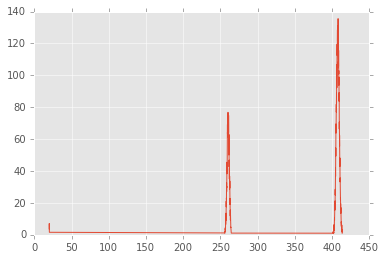

In [173]:
plt.plot(swf_zs['time_ns']/mus, swf_zs['ene_pes'])

In [174]:
s12 = find_S12(swf_zs)

In [175]:
len(s12)

3

In [176]:
s1=s12[0]
s2_1=s12[1]
s2_2=s12[2]

In [177]:
s1

,time_ns,ene_pes,indx
0,20025.0,3.703025,801
1,20050.0,6.584706,802
2,20075.0,7.054479,803
3,20100.0,5.314186,804
4,20125.0,3.660877,805
5,20150.0,2.914180,806
6,20175.0,2.432179,807
7,20200.0,1.574920,808


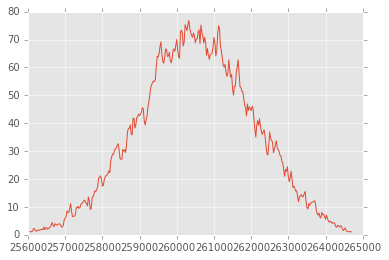

In [178]:
 plt.plot(s2_1['time_ns'],s2_1['ene_pes'])

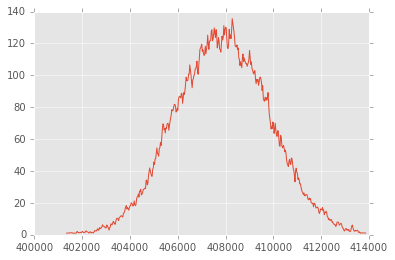

In [179]:
plt.plot(s2_2['time_ns'],s2_2['ene_pes'])

### An example with a long S2

In [182]:
len(s12)

2

In [181]:
stride = 40
print("thr = {} pes; srtide = {}".format(thr,stride))
cwfdf = wfm.get_waveforms(pmtcwf,event_number=2)
swf = wfm.add_cwf(cwfdf,PMT)
swf_zs = wfm.wf_thr(swf,threshold =thr)
s12 = wfm.find_S12(swf_zs, stride=stride)

thr = 0.931150514149 pes; srtide = 40


In [183]:
s1 = s12[0]
s2 = s12[1]

In [184]:
s1

,time_ns,ene_pes,indx
0,20025.0,10.698385,801
1,20050.0,21.936853,802
2,20075.0,21.374283,803
3,20100.0,16.052534,804
4,20125.0,10.821774,805
5,20150.0,6.923152,806
6,20175.0,4.631536,807
7,20200.0,3.653039,808
8,20225.0,2.198371,809
9,20250.0,1.653224,810


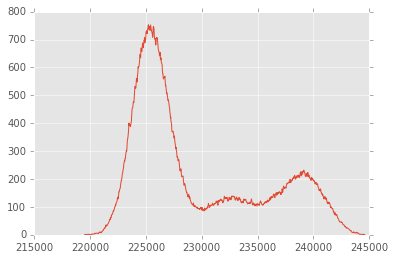

In [185]:
plt.plot(s2['time_ns'], s2['ene_pes'])

### Rebinning waveforms

In [186]:
def rebin_waveform(swf, stride = 40):
    """
    rebins the a waveform according to stride 
    The input waveform is a vector such that the index expresses time bin and the
    contents expresses energy (e.g, in pes)
    The function returns a DataFrame. The time bins and energy are rebinned according to stride
    """
    
    t = swf['time_ns'].values
    e = swf['ene_pes'].values
    I = swf['indx'].values
    n = len(swf)/int(stride)
    r = len(swf)%int(stride)
    
    lenb = n
    if r > 0: 
        lenb = n+1
    
    T = np.zeros(lenb)
    E = np.zeros(lenb)
    II = np.zeros(lenb, dtype=int)
    
    j=0
    for i in range(n):
        E[i] = np.sum(e[j:j+stride])
        T[i] = np.mean(t[j:j+stride])
        II[i] = I[(j+stride)/2]
        j+= stride
        
    if r > 0:
        E[n] = np.sum(e[j:])
        T[n] = np.mean(t[j:])
        II[n] = I[(len(swf) - j/2)]
    
   
    rbw={}
    rbw['ene_pes'] = E
    rbw['time_ns'] = T
    rbw['indx'] = II
    return pd.DataFrame(rbw)
    

##### S1 does not need to be rebinned, rebin only applies to S2

In [187]:
s2rb = rebin_waveform(s2, stride = 40)

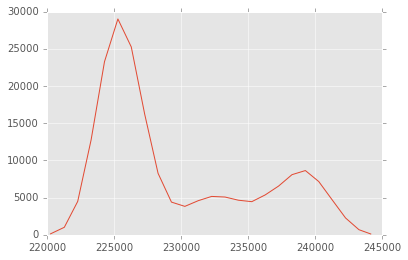

In [188]:
plt.plot(s2rb['time_ns'], s2rb['ene_pes'])

In [190]:
print("ene s2 = {} pes; ene s2rb = {} pes (must be the same)".format(np.sum(s2.ene_pes.values), 
                                                                     np.sum(s2rb.ene_pes.values)))

ene s2 = 196088.39102 pes; ene s2rb = 196088.39102 pes (must be the same)


###  t0 from S1

In [193]:
def find_t0(s1):
    """
    returns t0
    """
    emax = np.amax(s1.ene_pes.values)
    return s1.loc[lambda df: df.ene_pes.values ==emax, :]

In [196]:
print("t0 = {} mus".format(find_t0(s1).time_ns.values[0]/mus))

t0 = 20.05 mus


#### Energy and length of S2

In [197]:
def s2_energy(s2):
    """
    total energy in pes
    """
    return np.sum(s2.ene_pes.values)

In [198]:
def s2_length(s2):
    """
    s2 length in ns
    """
    t = s2.time_ns.values
    return t[-1] - t[0]

In [199]:
print('s2 energy = {} pes; s2 length = {} mus'.format(s2_energy(s2), s2_length(s2)/mus))

s2 energy = 196088.39102 pes; s2 length = 25.075 mus


In [200]:
print('s2rb energy = {} pes; s2rb length = {} mus'.format(s2_energy(s2rb), s2_length(s2rb)/mus))

s2rb energy = 196088.39102 pes; s2rb length = 23.9091666667 mus


#### Notice that rebinning introduces an error (of the order of the stride, e.g, 1 mus) in the length of s2.

### EP PMAPS

Compute now the PMAPS in the EP.
A EP PMAP is defined as the collection of S2 (bins of 1 mus) in each PMT of the EP. The collection is built
using the s2 obtained with the PMT sum 

In [202]:
def pmt_wf(cwfdf,pmtDF):
    """
    input: cwfdf: each colum is the wf for one PMT.
    output: wf is a list of waveform data frames
    time_ns = counts the time in ns
    ene_pes = conths the energy in pes
    returns a data frame with one data frame per PMT
    each pmt DF expresses the waveform in the PMT
    """
    
    NPMT = len(pmtDF)
    PMTWF = []
    for i in range(NPMT):
        adc_to_pes = pmtDF['adc_to_pes'][i]
        wf = cwfdf[i].values/adc_to_pes
        PMTWF.append(wfdf(np.array(range(len(wf)))*FP.time_DAQ, wf,np.array(range(len(wf)))))
    
        
    return PMTWF

In [203]:
pmtwf = pmt_wf(cwfdf,PMT)

In [205]:
def plot_pmtwf(PMTWF):
    """
    Plots pmtwf
    """
    
    pmtwf = PMTWF[0]
    plt.plot(pmtwf['time_ns']/mus,pmtwf['ene_pes'])
    ene = pmtwf['ene_pes'].values/12.
    time = pmtwf['time_ns'].values/mus
    plt.xlabel('t (mus)')
    plt.ylabel('E (pes)')
    plt.show()
    plt.figure(figsize=(12,12))
    for i in range(1,len(PMTWF)):
        ax1 = plt.subplot(3,4,i)
        pmtwf = PMTWF[i]
        plt.plot(pmtwf['time_ns']/mus,pmtwf['ene_pes'])
        plt.plot(time,ene)
    
    plt.show()
     
    

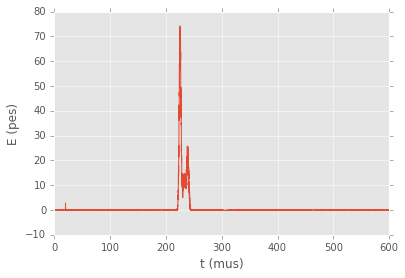

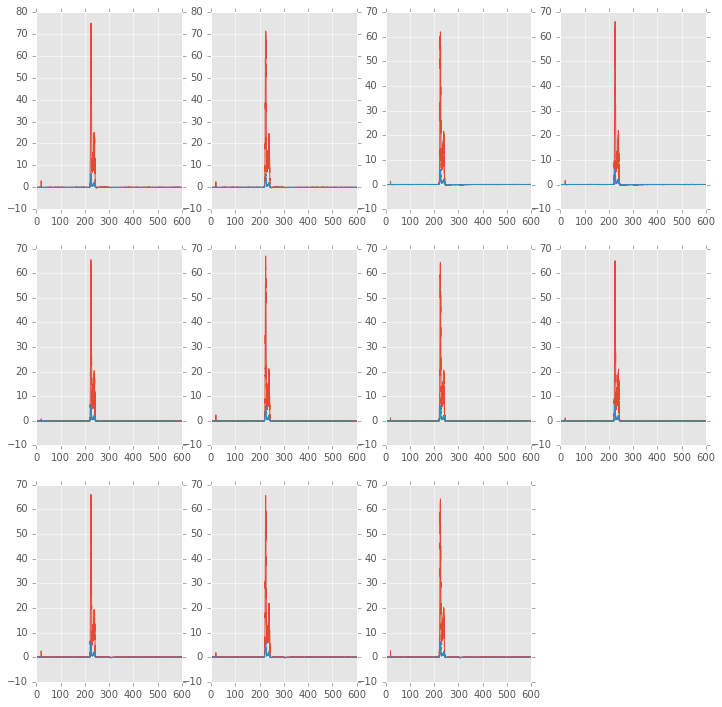

In [208]:
mpl.plot_pmtwf(pmtwf)

In [209]:
def plot_pmtwf_s2(PMTWF,s2):
    """
    Plots the pmtwf in the indexes of s2
    """
    plt.figure(figsize=(12,12))
    
    for i in range(12):
        ax1 = plt.subplot(3,4,i+1)
        pmtwf = PMTWF[i]
        plt.plot(pmtwf.time_ns.values[s2.indx.values[0]:s2.indx.values[-1]+1],
                 pmtwf.ene_pes.values[s2.indx.values[0]:s2.indx.values[-1]+1])
    
    plt.show()

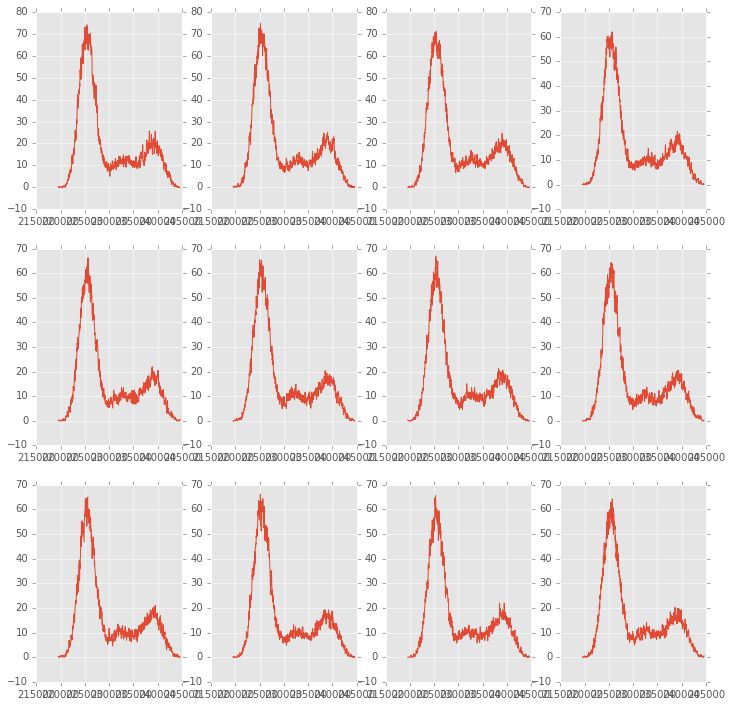

In [210]:
plot_pmtwf_s2(pmtwf,s2)

In [211]:
thr

0.9311505141490285

In [287]:
def pmaps_EP(pmtcwf,pmtDF,list_of_events=[0], thr = 1, stride=40):
    """
    computes pmaps in the EP plane
    Returns a list of S2PMAPS (one entry per event) and a t0 DataFrame
    S2PMAPS is a list of PMAPS of one entry per S2 found in the sum of PMTs
    Each EP PMAP is the collection of 12+1 S2s
    """
    NPMT = len(pmtDF)
    S2PMAP = []
    for event in list_of_events:
        # compute the sum function (swf), supress zeros (swf_zs) and finds s12 for swf_zs
        cwfdf = get_waveforms(pmtcwf,event_number=event)
        swf = add_cwf(cwfdf,pmtDF)
        swf_zs = wf_thr(swf,threshold =thr)
        s12 = find_S12(swf_zs, stride=stride)
        
        is2=0
        t0 = -999
        if len(s12) > 1:  #if s1 exists is s12[0]
            is2=1  #s2 starts in index 1 if s1 exists in 0 otherwise
            s1 = s12[0]
            t0 = find_t0(s1)
        
        S2L = []
        for s2 in s12[is2:]: #loop over s2 found is swf_zs
            PMTWF = pmt_wf(cwfdf,PMT) #wf for each of the PMTs
            #scan_pmtwf_s2(PMTWF,s2)
            
            PMAP = []
            s2rb = rebin_waveform(s2, stride = stride)
            PMAP.append(s2rb)
            for i in range(NPMT):
                pmtwf = PMTWF[i]
                pmtdf = wfdf(pmtwf.time_ns.values[s2.indx.values[0]:s2.indx.values[-1]+1], 
                                 pmtwf.ene_pes.values[s2.indx.values[0]:s2.indx.values[-1]+1],
                                 pmtwf.indx.values[s2.indx.values[0]:s2.indx.values[-1]+1])
                pmtrb = rebin_waveform(pmtdf, stride = stride)
                
                PMAP.append(pmtrb)
            S2L.append(PMAP)
        S2PMAP.append(S2L)
    return t0, S2PMAP
                                 
            

In [288]:
t0, s2pmap = pmaps_EP(pmtcwf,PMT,list_of_events=[0], thr = 1, stride=40)

In [289]:
t0

,time_ns,ene_pes,indx
1,20050.0,3.93118,802


In [290]:
t0.time_ns/mus

1    20.05
Name: time_ns, dtype: float64

In [291]:
len(s2pmap)  #one event

1

In [292]:
s2p = s2pmap[0] #one S2 in sum
len(s2p)

1

In [293]:
pmap = s2p[0] #pmap has dimension 12+1
len(pmap)

13

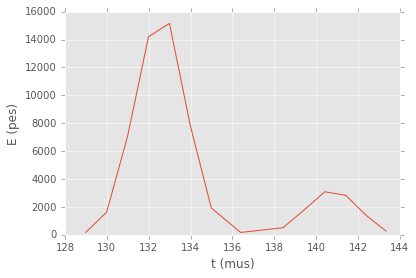

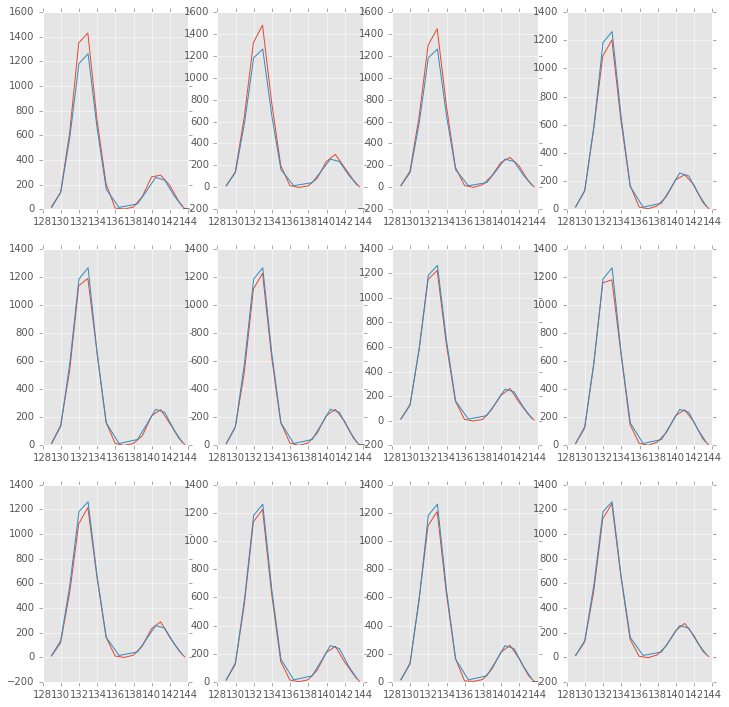

In [294]:
 plot_pmtwf(pmap)

In [225]:
s2pmap = pmaps_EP(pmtcwf,PMT,list_of_events=range(5), thr = 1, stride=40)

In [226]:
len(s2pmap)

5

In [227]:
s2p = s2pmap[1]
len(s2p)

1

In [228]:
pmap = s2p[0] #pmap has dimension 12+1
len(pmap)

13

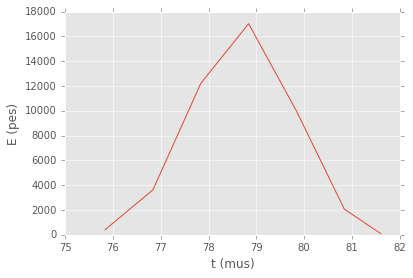

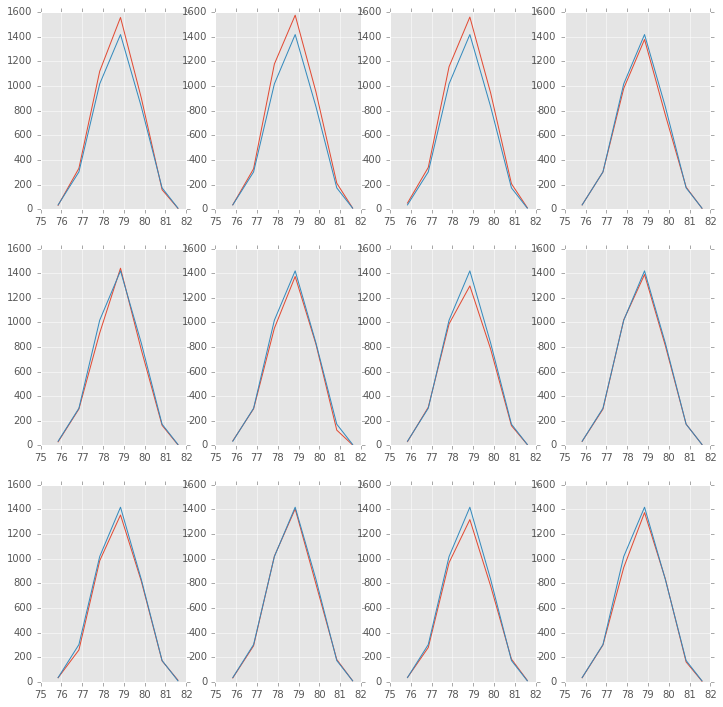

In [229]:
plot_pmtwf(pmap)

In [230]:
s2p = s2pmap[2]
len(s2p)

1

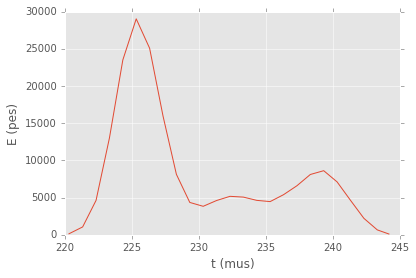

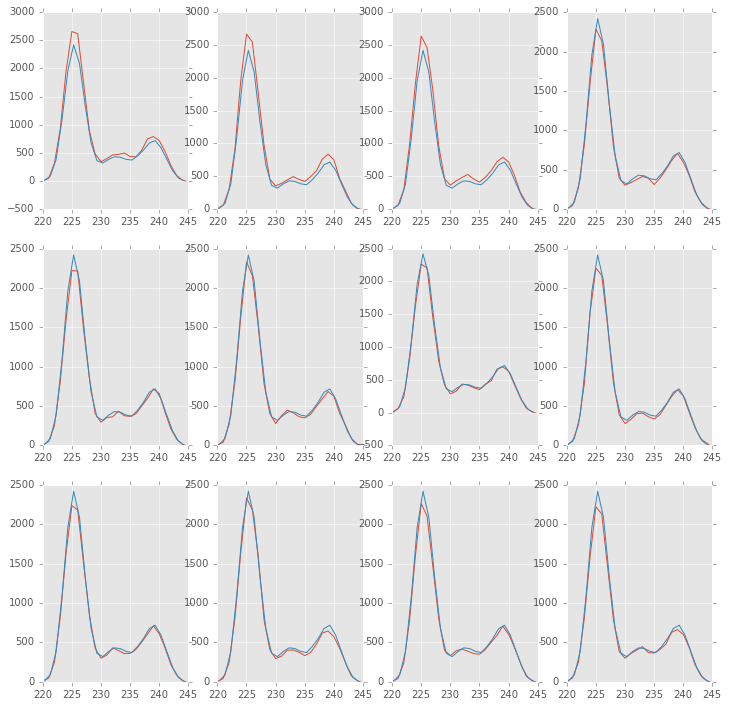

In [231]:
plot_pmtwf(s2p[0])

In [232]:
s2p = s2pmap[3]
len(s2p)

2

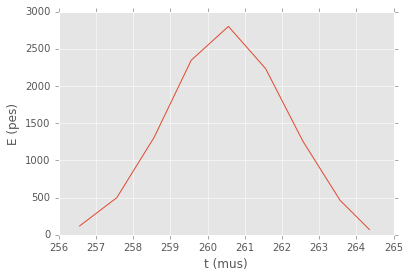

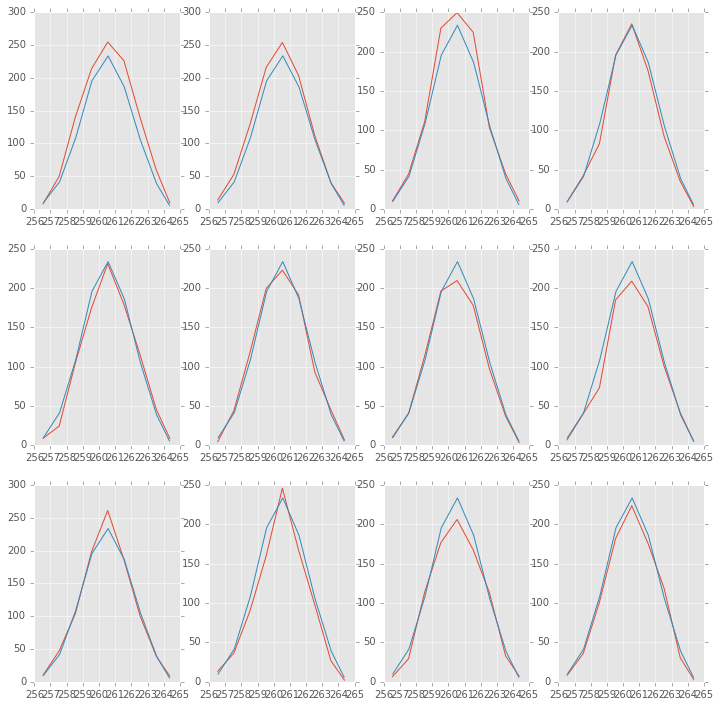

In [233]:
plot_pmtwf(s2p[0])

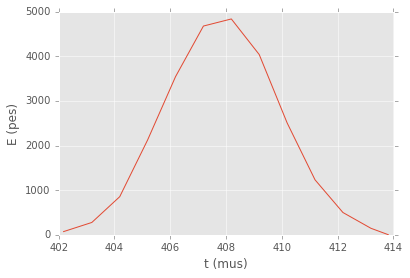

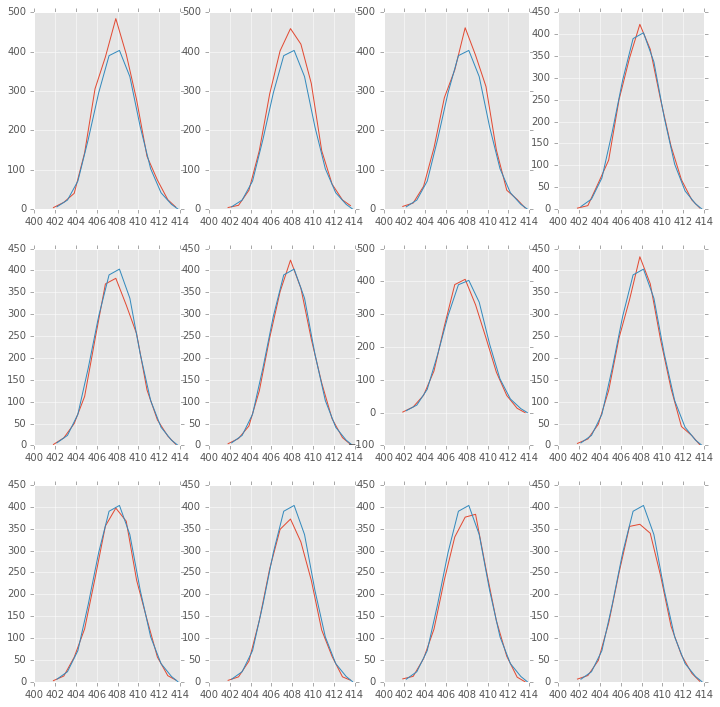

In [234]:
plot_pmtwf(s2p[1])

In [236]:
def wf_mus(wfns):
    """
    Takes as input a waveform expressed in ns and returns a waveform expressed in mus.
    """
    swf = {}
    swf['time_mus'] = wfns['time_ns']/mus
    swf['ene_pes'] = wfns['ene_pes'] 
    swf['indx'] = wfns['indx']
    return pd.DataFrame(swf)

##  SiPM PMAPS

### SiPM panel

Organize the SiPM as a PD panel, that is a collection of PD DataFrames 

1. items = number of sipm
2. One DataFrame per SiPM

In [238]:
def sipm_panel(sipmrwf, event_number=0):
    """
    Organize the SiPM as a PD panel, that is a collection of PD DataFrames 

    1. items = number of sipm
    2. One DataFrame per SiPM
    """
    sipmwf = sipmrwf[event_number]
    SIPM = {}
    NSIPM = sipmwf.shape[0]
    sipmwl = sipmwf.shape[1]
    for i in range(NSIPM):
        energy_pes = sipmwf[i]
        time_ns = np.array(range(sipmwl))*1e+3 #steps are mus
        indx = np.ones(sipmwl)*i
        SIPM[i] = wf_mus(wfdf(time_ns,energy_pes,indx))
    return pd.Panel(SIPM)

In [239]:
sipmrwf = h5f.root.RD.sipmrwf

In [240]:
sipmrwf

/RD/sipmrwf (EArray(10, 1792, 600), shuffle, zlib(1)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 218, 600)

In [242]:
sipmwf = sipmrwf[0]

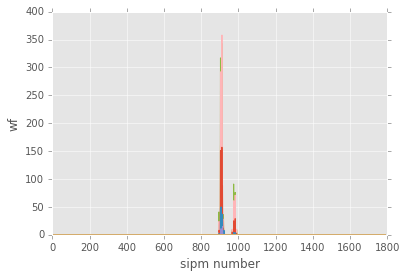

In [243]:
plt.plot(sipmwf)    
plt.xlabel('sipm number')
plt.ylabel('wf')

In [244]:
sipmwf.shape

(1792, 600)

In [246]:
sipmp = sipm_panel(sipmrwf, event_number=0)

In [247]:
sipmp

<class 'pandas.core.panel.Panel'>
Dimensions: 1792 (items) x 600 (major_axis) x 3 (minor_axis)
Items axis: 0 to 1791
Major_axis axis: 0 to 599
Minor_axis axis: ene_pes to time_mus

In [248]:
sipmp.shape

(1792, 600, 3)

In [249]:
sipmp.major_axis

RangeIndex(start=0, stop=600, step=1)

In [250]:
sipmp.minor_axis

Index([u'ene_pes', u'indx', u'time_mus'], dtype='object')

In [251]:
sipmp.items

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791],
           dtype='int64', length=1792)

In [252]:
s2p = s2pmap[0]
pmap = s2p[0]
s2 = pmap[0]

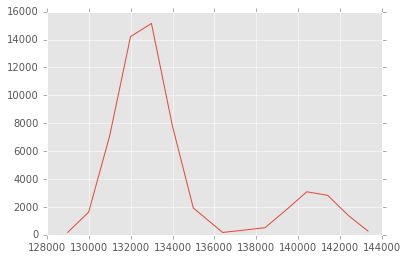

In [253]:
plt.plot(s2['time_ns'], s2['ene_pes'])

We take the s2 of the sum in bins of 1 ms and express it in mus for consistency with the SiPM plane

In [254]:
s2mus = wf_mus(s2)

In [255]:
s2mus.time_mus.values

array([ 128.98625 ,  129.9875  ,  130.9875  ,  131.9875  ,  132.9875  ,
        133.9875  ,  134.9875  ,  136.391875,  138.4125  ,  139.4125  ,
        140.4125  ,  141.4125  ,  142.4125  ,  143.3375  ])

In [257]:
s2ti = s2mus.time_mus.values[0]
s2tf = s2mus.time_mus.values[-1]

In [258]:
s2ti

128.98625000000001

In [259]:
s2tf

143.33750000000001

For each sipm in the TP we select only the bins defined by s2

In [260]:
sipm =sipmp[0]

In [262]:
def sipm_s2(sipmdf, s2df):
    """
    Takes a sipm DF and an s2df
    Returns a DF with the sipm values in the range specified by s2
    """
    s2ti = s2df.time_mus.values[0]
    s2tf = s2df.time_mus.values[-1]
    dfl = sipmdf.loc[lambda df: df.time_mus.values >= s2ti, :]
    dfu = dfl.loc[lambda df: df.time_mus.values < s2tf, :]
    return dfu


In [265]:
def sipmp_s2(sipmp, s2df, thr=0.5):
    """
    Takes a sipm panel and a s2df
    Returns a sipm panel with a collection of sipm DF such that:
    1. the range of the sipm is specified by s2
    2. the sipm energy are above threshold.
    """
    SIPM={}
    j=0
    for i in sipmp.items:
        sipm = sipmp[i]
        sipms2 = sipm_s2(sipm, s2df)
        if np.sum(sipms2).ene_pes > thr:
            SIPM[j] = sipms2
            j+=1
    return pd.Panel(SIPM)
    

In [266]:
sipms2p  = sipmp_s2(sipmp, s2mus, thr=0.5*pes)

In [267]:
sipms2p

<class 'pandas.core.panel.Panel'>
Dimensions: 27 (items) x 15 (major_axis) x 3 (minor_axis)
Items axis: 0 to 26
Major_axis axis: 129 to 143
Minor_axis axis: ene_pes to time_mus

#### SIPMS2P

A SIPMS2P is a SiPM panel selected by S2 (e.g, the S2 of the EP sum) and by energy threshold

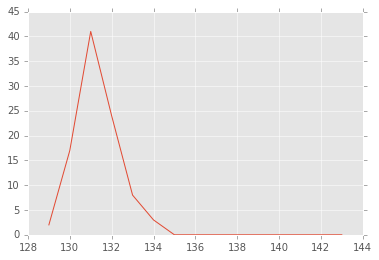

In [268]:
plt.plot(sipms2p[0].time_mus.values,sipms2p[0].ene_pes.values)

In [269]:
sipms2p[0].indx.values # all indx are the same and give the number of the sipm

array([ 896.,  896.,  896.,  896.,  896.,  896.,  896.,  896.,  896.,
        896.,  896.,  896.,  896.,  896.,  896.])

In [270]:
sipms2p[0].indx.values[0]

896.0

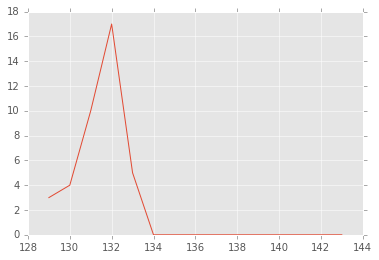

In [271]:
plt.plot(sipms2p[1].time_mus.values,sipms2p[1].ene_pes.values)

In [273]:
sipms2p[1].indx.values[0]

897.0

In [274]:
def sipm_hit_index(sipmp):
    """
    Store the indexes of the (sipm number)
    """
    hi =[]
    for i in sipmp.items:
        sipm = sipmp[i]
        hi.append(sipm.indx.values[0])
    return pd.Series(hi)

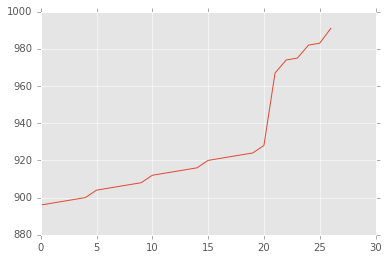

In [275]:
plt.plot(sipm_hit_index(sipms2p).values)

In [278]:
def sipmps2p_energy(sipms2p):
    """
    Takes a sipms2p as input
    Returns a DataFrame with the index and the energy in the SiPM as columns:
    
    """
    
    SIPM=[]
    for i in sipms2p.items:
        swf = {}
        swf['ene_pes'] = np.sum(sipms2p[i].ene_pes.values)
        swf['indx'] = sipms2p[i].indx.values[0]
        SIPM.append(swf)
        
    return pd.DataFrame(SIPM)

In [279]:
sipmps2p_e = sipmps2p_energy(sipms2p)

In [280]:
sipmps2p_e

,ene_pes,indx
0,95.0,896.0
1,39.0,897.0
2,10.0,898.0
3,15.0,899.0
4,4.0,900.0
5,993.0,904.0
6,350.0,905.0
7,110.0,906.0
8,233.0,907.0
9,43.0,908.0


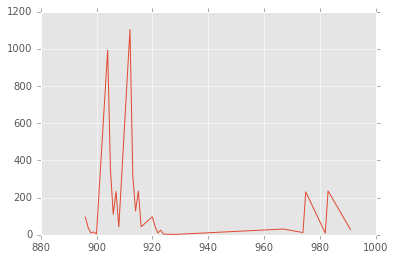

In [282]:
plt.plot(sipmps2p_e.indx.values,sipmps2p_e.ene_pes.values)

### PMAPS

#### Put together EP PMAPS and SiPM panel

###  PMAP class

In [321]:
class PMAP:
    """
    A simple class to hold the EP and TP pmap info
    """
    def __init__(self, t0):
        """
        inits the class with t0
        
        """
        
        self.t0 = t0
        self.s2PMAP  = []
        self.epPMAP  = []
        self.sipmS2P  = []
        
    def add_pmap(self,s2pmap, sipms2p, epmap):
        self.s2PMAP.append(s2pmap)
        self.sipmS2P.append(sipms2p)
        self.epPMAP.append(epmap)
    
    
    def nof_s2(self):
        return len(self.s2PMAP)
    
        
        

In [322]:
def compute_pmaps(pmtcwf,sipmrwf,PMT,thr_s2 = 1, trh_sipm = 0.5, stride=40, list_of_events=[0]):
    """
    computes pmaps in the EP and SIPMS2P in the TP
    
    input:
    pmtcwf:   pmt corrected waveform
    sipmrwf:  sipm raw waveform
    PMT:      data frame with PMT constants
    thr_s2:    threshold for S2 search  in pes
    thr_sipm:    threshold for SIPM energy
    stride:   defines the rebinning: stride = 40 rebins from 25 ns to 1 mus
    """
    t0, s2pmap = pmaps_EP(pmtcwf,PMT,list_of_events=list_of_events, thr = thr_s2, stride=stride)
    
    
    event = 0
    PMAPS=[]
    for s2p in s2pmap:   # one s2p per event
        sipmp = sipm_panel(sipmrwf, event_number=event) #sipm panel
        pm = PMAP(t0)
        for pmap in s2p:  #each pmap corresponding to one S2 in the EP plane
            s2pmap = wf_mus(pmap[0])  #s2pmap corresponds to the sum of pmts: DF in mus
            EPMAP = []
            for s2ep in pmap[1:]:
                EPMAP.append(wf_mus(s2ep))
            sipms2p  = sipmp_s2(sipmp, s2pmap, thr=trh_sipm)  #sipm2p
            pm.add_pmap(s2pmap, sipms2p, EPMAP)
        PMAPS.append(pm)
        event+=1
    return PMAPS
           
            

In [323]:
%time PMAPS = compute_pmaps(pmtcwf,sipmrwf,PMT, thr_s2 = 1, trh_sipm = 0.5, stride=40, list_of_events=range(5))

CPU times: user 20.3 s, sys: 179 ms, total: 20.5 s
Wall time: 20.7 s


In [324]:
pmap = PMAPS[0]

In [325]:
ns2 = pmap.nof_s2()

In [312]:
ns2

1

In [326]:
s2_pmap = pmap.s2PMAP[0]
sipms2p = pmap.sipmS2P[0]
epmap = pmap.epPMAP[0]

In [327]:
s2_pmap

,ene_pes,indx,time_mus
0,174.191028,5160,128.986250
1,1626.934983,5180,129.987500
2,7066.986664,5200,130.987500
3,14201.915863,5220,131.987500
4,15152.946564,5240,132.987500
5,7824.851257,5260,133.987500
6,1925.739123,5280,134.987500
7,167.350621,5300,136.391875
8,507.595228,5320,138.412500
9,1763.618010,5340,139.412500


In [315]:
sipms2p

<class 'pandas.core.panel.Panel'>
Dimensions: 27 (items) x 15 (major_axis) x 3 (minor_axis)
Items axis: 0 to 26
Major_axis axis: 129 to 143
Minor_axis axis: ene_pes to time_mus

In [329]:
len(epmap)

12

In [330]:
epmap[0]

,ene_pes,indx,time_mus
0,19.533430,5159,128.9625
1,135.691940,5179,129.9625
2,619.843994,5199,130.9625
3,1350.963623,5219,131.9625
4,1430.673584,5239,132.9625
5,730.938965,5259,133.9625
6,207.252014,5279,134.9625
7,8.357598,5299,135.9625
8,1.169687,5319,136.9625
9,16.460835,5339,137.9625


In [ ]:
def wf_thr(wf,threshold=1):
    """
    return a zero supressed waveform (more generally, the vaules of wf above threshold)
    """
    return wf.loc[lambda df: df.ene_pes.values >threshold, :]

In [ ]:
def s12_list(pmtcwf,pmtDF,list_of_events=[0], thr = 2, stride=40):
    """
    1) adds the waveforms (calibrated)
    3) Supresses zeros
    4) finds s1 and s2 objects (with a stride of 1 mus and a threshold of 2 pes)
    """
    
    S12 =[]
    for event in list_of_events:
        cwfdf = get_waveforms(pmtcwf,event_number=event)
        swf = add_cwf(cwfdf,pmtDF)
        swf_zs = wf_thr(swf,threshold =thr)
        s12 = find_S12(swf_zs, stride=stride)
        S12.append(s12)
    return S12
        
        

In [ ]:
s12l = s12_list(pmtcwf,PMT,list_of_events=range(10), thr = 2, stride=40)

In [ ]:
def scan_S12(s12l):
    """
    Plots S1 and S2 for each S12
    """
    
    for s12 in s12l:
        print("number of s12 signals = {}".format(len(s12)))
        s1 = s12[0] #s1 is a series
        print("s1 = {}".format(s1))
        
        for s2 in s12[1:]:
            plt.plot(s2['time_ns'],s2['ene_pes'])
        plt.show()
        wait()

In [ ]:
scan_S12(s12l)

No need to rebin S1, enough to rebin S2

In [ ]:
len(s12l)

In [ ]:
s12=s12l[1]

In [ ]:
len(s12)

In [ ]:
s1 = s12[0]
s2 = s12[1]

In [ ]:
s1

In [ ]:
t0 = find_t0(s1)

In [ ]:
t0

In [ ]:
rbs2 = rebin_waveform(s2, stride = 40)

In [ ]:
rbs2

In [ ]:
s2_energy(rbs2)

In [ ]:
s2_length(rbs2)/mus

In [ ]:
plt.plot(rbs2.time_ns.values,rbs2.ene_pes.values)

In [ ]:
def S12(s12l):
    """
    computes s1, rebins S2
    """
    
    print("list s12l has length = {}".format(len(s12l)))
    j= 0
    EPL =[]
    
    for s12 in s12l:
        EP = {}
        print('event number {}'.format(j))
        #print("number of s12 signals = {}".format(len(s12)))
        ll=0
        if len(s12) > 1:
            s1 = s12[0] #s1 is a series
            #print("s1 = {}".format(s1))
            t0 = find_t0(s1)
            #print("t0 = {}".format(t0))
            EP['t0_mus'] = t0.time_ns.values[0]/mus
            ll=1
        else:
            print('no S1 found')
            EP['t0_mus'] = -999
        
        k = 0
        epes = 0
        lmax = 0
        for s2 in s12[ll:]:
            #print('s2 number {}'.format(k))
            rbs2 = rebin_waveform(s2, stride = 40)
            #print("s2 = {}".format(rbs2))
            es2 = s2_energy(rbs2)
            ls2 = s2_length(rbs2)
            #print("energy (pes) = {} length (mus) = {}".format(es2,ls2/mus))
            epes += es2
            if ls2 > lmax:
                lmax = ls2
            k+=1
        
        EP['n_s2'] =k
        EP['ene_pes'] = epes
        EP['lmax_mus'] = lmax/mus 
        EPL.append(EP)
        j+=1
    return pd.DataFrame(EPL)
    

In [ ]:
s12df = S12(s12l)

In [ ]:
s12df

In [ ]:
t0_zs = s12df.loc[lambda df: df.t0_mus.values >=0, :]

In [ ]:
t0_zs

In [ ]:
def histo_S12(s12df, nbins=10):
    """
    histograms for s12 DF
    """
    HSimple1(s12df.ene_pes,nbins,title='energy pes',xlabel = 'ene')
    HSimple1(s12df.lmax_mus,nbins,title='track  length (mus)',xlabel = 'lmax (mus)')
    HSimple1(s12df.n_s2,nbins,title='number of S2',xlabel = 'n S2')
    HSimple1(s12df.t0_mus,nbins,title='t0',xlabel = 't (mus)')
    
    plt.show()
    

In [ ]:
histo_S12(t0_zs, nbins=10)

In [ ]:
cwfdf = get_waveforms(pmtcwf,event_number=0)
swf = add_cwf(cwfdf,PMT)
swf_zs = wf_thr(swf,threshold =thr)
s12 = find_S12(swf_zs, stride=stride)

In [ ]:
pmtwf = pmt_wf(cwfdf,PMT)

In [ ]:
len(pmtwf)

In [ ]:
scan_pmtwf(pmtwf)

In [ ]:
len(s12)

In [ ]:
s2 = s12[1]

In [ ]:
plt.plot(s2['time_ns'],s2['ene_pes'])

In [ ]:
scan_pmtwf_s2(pmtwf,s2)

In [ ]:
s2s = pd.Series(s2pmap)

In [ ]:
s2s.index

In [ ]:
s2s.values

In [ ]:
dst = pd.HDFStore('../../data/Na/WF_Na_test_DST.h5') 

In [ ]:
dst['s2pmap'] = s2s

In [ ]:
dst.close()

In [ ]:
pdst = pd.HDFStore('../../data/Na/WF_Na_test_DST.h5')
ps2map = pdst['s2pmap']
s2pmap_ = ps2map.values
print('events in pmap = {}'.format(len(s2pmap_)))
event=2
s2p = s2pmap_[event]
print('number of s2 in event {} = {}'.format(event,len(s2p)))
pmap = s2p[0]
print('length of  pmap = {}'.format(len(pmap)))

In [ ]:
scan_pmtwf(pmap)

In [ ]:
s2 = pmap[0]

In [ ]:
len(s2)

In [ ]:
plt.plot(s2['time_ns']/mus,s2['ene_pes'])    
plt.xlabel('t (mus)')
plt.ylabel('E (pes)')